# Import Packages

In [1]:
import nidaqmx
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.animation

# Define Functions

In [2]:
def CV_potential_sweep():
   
    ''' 
    This function writes a program potential used for linear sweep voltammetry into the ao0 output of the 
    potentiostat to set Ein, which then sets Ecell when the counter electrode is connected. 
    
    At the same time potential acquisitions are made on input channels ai0 and ai1 to measure 
    Ecell and iwRm.
    
    The sweep rate, initial hold time and program potential initial value and vertices should be 
    defined in Code Block 1 prior to running this function. 

    Returns:     
        total_data_WE = cell potential during program potential (ai0) 
        total_data_RM = iwRm during program potential (ai1)
        np.array(total_data_RM)/Rm = iwRm during the program potential 
        np.abs(np.arange(0, len(total_data_WE), 1)/samp_rate) = time array during the program potential
    
    '''  
    
    
    
    '''Get device name '''    
    # get a list of all devices connected
    all_devices = list(nidaqmx.system.System.local().devices)
    # get name of first device
    dev_name = all_devices[0].name
    #print(dev_name)
    
    
    
    ''' add DAQ channels and define measurement parameters'''
    with nidaqmx.Task() as task_i, nidaqmx.Task() as task_o:
        
        # add ai0 & ai1 input channels for reading potentials. add ao0 output channels for setting potential
        task_i.ai_channels.add_ai_voltage_chan(dev_name + "/ai0:1", min_val=-10.0, max_val=10.0)
        task_o.ao_channels.add_ao_voltage_chan(dev_name + "/ao0", min_val=-10.0, max_val=10.0)

        # define sampling rate and total samples acquired per channel for input & output channels
        task_i.timing.cfg_samp_clk_timing(rate = samp_rate, samps_per_chan=samp_num_tot)
        task_o.timing.cfg_samp_clk_timing(rate = samp_rate, samps_per_chan=samp_num_tot) 

        # set up a digital trigger for the output channel to set the potential.  Should be commented out for myDAQs
        #task_o.triggers.start_trigger.cfg_dig_edge_start_trig('/'+ dev_name +'/ai/StartTrigger')

        # create empty lists to populate
        total_data_WE = [] # cell potential in V
        total_data_RM = [] # iwRm potential in V

        # define output channel task. Task will only execute when the output channel trigger is activated
        task_o.write(pot_profile) #, auto_start = False)
        task_o.start() 
        
        
        
        ''' Set up plot during data acquisition'''
        # set up a 2 x 2 grid for the plot
        grid = plt.GridSpec(2, 1, wspace=0.3, hspace=0.2)
        fig = plt.figure(figsize = (14, 12))        
        
        # set right edge of plot to be at 80% of fig width and bottom to be at 20% of fig height to fit everything.
        plt.subplots_adjust(right=0.8)
        plt.subplots_adjust(bottom=0.2)
        
        #Define positions of 3 subplots
        ax1 = fig.add_subplot(grid[1, 0])
        ax2 = fig.add_subplot(grid[0, 0])
        #ax3 = fig.add_subplot(grid[1, 1])#, sharex = ax2)
        plt.ion()
        fig.show()
        fig.canvas.draw()


        '''Buffer callback function'''
        def cont_read(task_handle, every_n_samples_event_type,
                     number_of_samples, callback_data):
            
            
            '''
            Define a 'callback' function to execute when the buffer is full
            
            When this funtion is called a subset of samples are acquired at ai0 and ai1 and then appended 
            to the lists 'total_data_WE'and 'total_data_RM'. Then the CV plot is updated with this new data. 
             '''
            

            # Acquire subset of samples and store data in a temporary list
            temp_samples = task_i.read(number_of_samples_per_channel=buffer_size)
            # add acquired data to list storing all data
            total_data_WE.extend(temp_samples[0])
            total_data_RM.extend(temp_samples[1])
            
            # calculate time profile (for plotting)
            total_time_profile = np.abs(np.arange(0, len(total_data_WE), 1)/samp_rate)
            # calculate current at Rm (for plotting)
            Rm_current = np.array(total_data_RM)/Rm
          
            
            # Return size of 'total_data' and update subplots every time buffer is full
            #print(len(total_data_RM))
                        
            ax1.clear()
            ax1.set_title('Cyclic Voltammogram', fontsize = 16)
            ax1.tick_params(axis='both',which='both',direction='in',right=True, top=True)
            ax1.set_xlabel('$E_{\mathrm{cell}}$ / V', fontsize = 16)
            ax1.set_ylabel('$i_{\mathrm{w}}$ / A', fontsize = 16)
            ax1.ticklabel_format(axis = 'y', style='sci', scilimits = (-2, 3)) 
            ax1.plot(total_data_WE, Rm_current)
            
            ax2.clear()
            ax2.set_title('$E_{\mathrm{cell}}$ and $i_{\mathrm{w}}R_{\mathrm{m}}$ vs Time', fontsize = 16)
            ax2.tick_params(axis='both',which='both',direction='in',right=True, top=True)
            # ax2.tick_params(labelbottom=False) 
            ax2.set_xlabel('Time / s', fontsize = 16)
            ax2.set_ylabel('Potential / V', fontsize = 16)
            ax2.plot(total_time_profile, total_data_WE, label = '$E_{\mathrm{cell}}$')
            ax2.plot(total_time_profile, total_data_RM, label = '$i_{\mathrm{w}}R_{\mathrm{m}}$')
            ax2.legend()

            # redrew plot with new data
            fig.canvas.draw()
            
            # callback function must return an integer 
            return 5

        
        '''
        Define buffer size and callback function executed every time buffer is full. 
        
        Note that the buffer size includes samples from all channels. E.g. if you're collecting 100 samples
        over 5 channels then a buffer size of 100*5 = 500 will be filled once every channel acquires 100 
        samples. 
        '''
        task_i.register_every_n_samples_acquired_into_buffer_event(buffer_size, cont_read)
        

  
        # start task to read potential at inputs. This will trigger output to begin potenial sweep
        task_i.start()
            
        
        # need an input here for some reason. Press any key to end
        input('Must press Enter to end execution of code block')
        
        
    # return data
    return total_data_WE, total_data_RM, np.array(total_data_RM)/Rm, np.abs(np.arange(0, len(total_data_WE), 1)/samp_rate)

In [3]:
def calc_closest_factor(num, fac):
    """Calculates the highest factor of the number 'num' less than or equal to 'fac'
    
    Inputs:
        num = number you want to find factors for
        fac = upper bound for factors searched
    
    Returns:
        highest factor of 'num' less than or equal to 'fac'
        
    """    
    while num%fac != 0:
        fac -= 1
        
    return int(fac)

# Define potential profile for CV

Code block 1 constructs the potential profile used to the linear sweep. This potential profile consists 
of 3 sections: 

 1) a forward potential sweep from f_start_pot to f_end_pot. <br>
 2) a backwards sweep from r_start_pot to r_end_pot.l <br>
 3) a return potential sweep which returns the WE potential to some point (usually OCV) 

The total time for each section is determined by the number of samples sent to the output channel and the sampling rate. You should check the sweep rate and the bounds of the profile carefully to prevent any unwanted reactions in your CV.

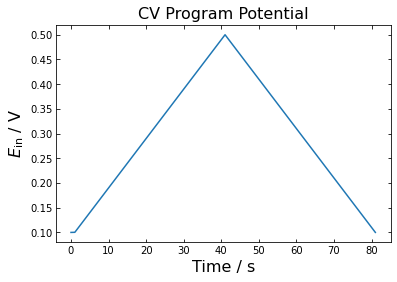

In [10]:
'''Code block 1'''

import matplotlib
%matplotlib inline

# sampling rate (samples/s)  Use an integral multiple of 120/suse at least 3600 per volt
samp_rate = 3600   

# scan rate (V/s)
scan_rate = .01

# Rm resistance in Ohms
Rm = 10000

'''Set up potential profile'''
# hold time before sweep
h_time = 0.3  # hold time before sweep in seconds
ocp = 100 / 1000
# potential bounds for each section
f_start_pot = ocp - 0  # Initial potential (should be same a )

f_end_pot = ocp + 0.4   # First vertex potential

r_start_pot = f_end_pot
r_end_pot = .1 # Second vertex potential

return_start_pot = r_end_pot
return_end_pot = f_start_pot


'''Total time required for each section'''
f_time = np.abs((f_end_pot - f_start_pot)/scan_rate)
r_time = np.abs((r_end_pot - r_start_pot)/scan_rate)
return_time = np.abs((return_end_pot - return_start_pot)/scan_rate)

'''Voltage array to be set for each section'''
h_profile = np.linspace(f_start_pot, f_start_pot, int(samp_rate*h_time) )
f_profile = np.linspace(f_start_pot, f_end_pot, int(samp_rate*f_time) )
r_profile = np.linspace(r_start_pot, r_end_pot, int(samp_rate*r_time) )
return_profile = np.linspace(return_start_pot, return_end_pot, int(samp_rate*return_time))

# potential profile is simply the individual potential profiles of each sections combinedd
pot_profile = np.concatenate((h_profile, f_profile, r_profile, return_profile))

# total sample number
samp_num_tot = len(pot_profile)
# buffer size (must be a factor of samp_num_tot). Buffer size is set to the largest number that is at least 
# 15 times smaller than 'samp_num_tot'. This ensures we have at least 15 updates per CV run
#buffer_size = calc_closest_factor(samp_num_tot, round(samp_num_tot/15))
buffer_size = 3600#round(200/scan_rate)

# round off sample size 
additional_hold_sample = 0

# round off sample size to be a multiple of round(200/scan_rate)
n = additional_hold_sample + samp_num_tot

while n%buffer_size != 0:
    additional_hold_sample += 1
    n = additional_hold_sample + samp_num_tot

# additional hold to keep total scan number a multiple of the buffer size
h2_profile =  np.linspace(f_start_pot, f_start_pot, additional_hold_sample)

# recalculate potential profile and total sample number
pot_profile = np.concatenate((h2_profile, pot_profile))
samp_num_tot = len(pot_profile)

'''Check potential profile to be set'''
plt.title('CV Program Potential', fontsize = 16)
plt.xlabel('Time / s', fontsize = 16)
plt.ylabel('$E_{\mathrm{in}}$ / V', fontsize = 16)
plt.tick_params(axis='both',which='both',direction='in',right=True, top=True)
plt.plot(np.arange(0, len(pot_profile), 1)/samp_rate, pot_profile)

In [11]:
'''Set Ein on pstat/gstat'''

# Get device name
# get a list of all devices connected
all_devices = list(nidaqmx.system.System.local().devices)
# get name of first device
dev_name = all_devices[0].name
#print(dev_name)
    
''' add DAQ channels and define measurement parameters'''
with nidaqmx.Task() as task_i, nidaqmx.Task() as task_o:
        
# add ai0 & ai1 input channels for reading potentials. add ao0 output channels for setting potential
    task_i.ai_channels.add_ai_voltage_chan(dev_name + "/ai0:1")
    task_o.ao_channels.add_ao_voltage_chan(dev_name + "/ao0", min_val=-10.0, max_val=10.0)
    task_o.write(f_start_pot)
    task_o.start() 

# CV Measurement

Code block 2 writes the potential profile defined in code block 1 and collects the CV data. The CV plot should update in real time (every time the 200 sample buffer is full). 

You may terminate the measurement with the enter key. Once the measurement concludes you will be asked to enter a filename for the measurement. This will be the filename used for the saved plot and data.

<IPython.core.display.Javascript object>


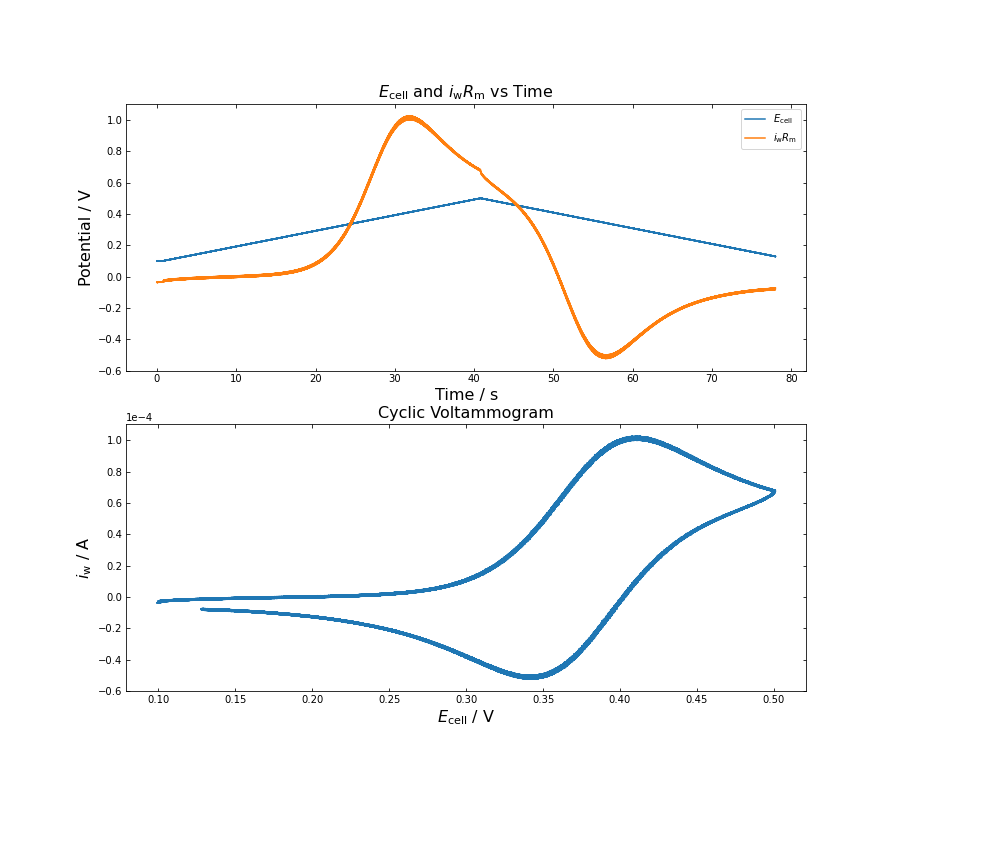

In [ ]:
'''Code block 2'''

import matplotlib
%matplotlib notebook
import IPython
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 70em; width:120em}</style>"))

# Used for 
#grid = plt.GridSpec(2, 2, wspace=0.3, hspace=0.4)


# Set potential profile and acquire data from CV
A = CV_potential_sweep()

# ask for the name of measurement this will be used for the filenames for the exported data and plots
filename = input('Name of measurement:')

# save CV plot and data once measurements is terminated
plt.savefig(filename + '.png', dpi = 300, bbox_inches='tight')

#export data
exported_data = pd.DataFrame({'WE potential': A[0], 
                    'Rm potential': A[1], 'Rm current': A[2], 'Time (s)': A[3]})
exported_data.to_csv(filename + '.txt', index = False)

            



# Importing Data & Comparing Different Datasets

Code block 3 im
ports specified data from different measurements into a dictionary and plots everything in a single
graph. Enter the text files into the list named 'file_list'. Terminate the interactive window under code block 2.

In [ ]:
# add file names of files you want to read
file_list = ['wft.txt',
            '5-v=1.txt']

# create dictionary to populate
file_dict = {}

# add relevant files to dictionary
for file in file_list:
    file_dict[file.replace('.txt', '')] = pd.read_csv(file)


'''plot all data in dictionary'''
fig, ax = plt.subplots(figsize = (14, 7))
plt.title('CV data')

for file in file_dict.keys():
    file_dict[file].plot(kind = 'line', x = 'WE potential', y = 'Rm current', label = file, ax =ax)
    

ax.set_title('Cyclic Voltammogram', fontsize = 16)
ax.set_ylabel('Current/A')
ax.tick_params(axis='both',which='both',direction='in',right=True, top=True)
ax.set_xlabel('$E_{\mathrm{cell}}$ / V', fontsize = 16)
ax.set_ylabel('$i_{\mathrm{w}}$ / A', fontsize = 16)
ax.ticklabel_format(axis = 'y', style='sci', scilimits = (-2, 3)) 
#ax.set_aspect('equal', 'box')
#ax.set_xlim((0, 500))
#ax.set_ylim((-0.03, 0.03))
plt.tight_layout()
plt.legend(loc=2)

plt.savefig('no')

